In [1]:
%matplotlib notebook

# Benchmarking BCI pipelines across dataset: the MOABB approach

Reproducible Research in BCI is difficult:

- data and code often not available
- exotic format for EEG dataset, unconventional programming language or environment
- preprocessing parameters not detailed, even if they have a significant impact on the results
- evaluations conducted on cherrypicked subjects, sessions or classes


This is waste of time for everyone. The Mother of all BCI Benchmarks (MOABB) allows to:

- Build a comprehensive benchmark of popular BCI algorithms applied on an extensive list of freely available EEG datasets.
- The code is available on github, serving as a reference point for the future algorithmic developments.
- Algorithms can be ranked and promoted on a website, providing a clear picture of the different solutions available in the field.

This project will be successful when we read in an abstract "... the proposed method obtained a score of 89% on the MOABB, outperforming the state of the art by 5% ...".

## A quick tour of MOABB

It is simple as ```pip install moabb``` and listening to this short tutorial!

MOABB is an open science project, build on the rich ecosystem of Python: [MNE](https://mne.tools/stable/index.html) for handling and processing EEG, [scikit-learn](https://scikit-learn.org/stable/) for making machine learning pipelines and classifiers and [pandas](https://pandas.pydata.org/) to share, plot and compute statistics on the results.

MOABB is structured around five main concepts:
1. Datasets
1. Paradigms (MI, SSVEP and P300)
1. Pipelines
1. Evaluations
1. Statistics and visualization

<img src="https://raw.githubusercontent.com/NeuroTechX/moabb/master/images/architecture.png" style="height:400px">

## Let's get started with BCI-Competition IV-2a dataset

First, you need to pick up a dataset. For this example, we will use the well known dataset 2a from BCI competition IV. This dataset is now part of the [BNCI project](http://bnci-horizon-2020.eu/database/data-sets):

In [2]:
from moabb.datasets import BNCI2014001

dataset = BNCI2014001()
print("There is {} subjects and {} sessions in this dataset".format(
    len(dataset.subject_list), dataset.n_sessions)
)

There is 9 subjects and 2 sessions in this dataset


MOABB automatically fetch the data on your computer (storing it in `mne_data` folder by default). It is possible to get the data as [MNE type](https://mne.tools/stable/generated/mne.Epochs.html) in a dictionary structure or as [Numpy's ndarray](https://numpy.org/doc/stable/reference/generated/numpy.ndarray.html). Using MNE Epochs, it is possible to benefit from the all existing function to get a better grasp of the data. The MNE data are stored in a dictionary of subjects, containing a dictionary of session, containing a dictionary of runs or blocks.

MNE offers nice possibilities to display the electrodes positions and names, to visualize the raw data or to see the power spectral density:

<IPython.core.display.Javascript object>


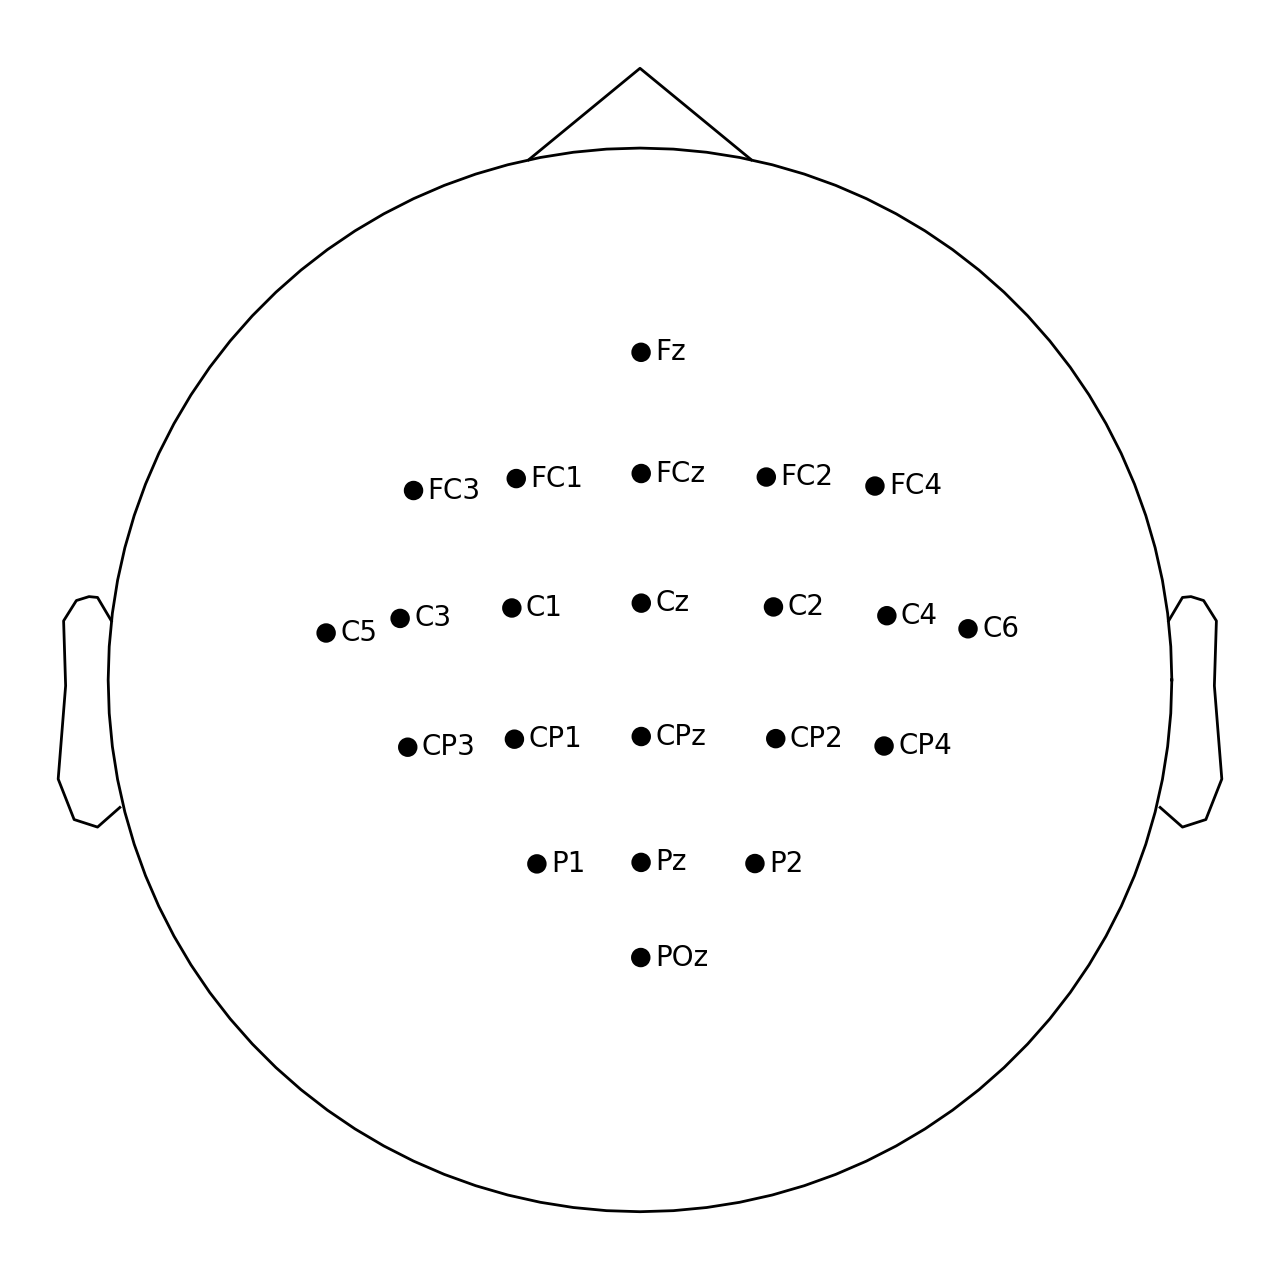

<IPython.core.display.Javascript object>


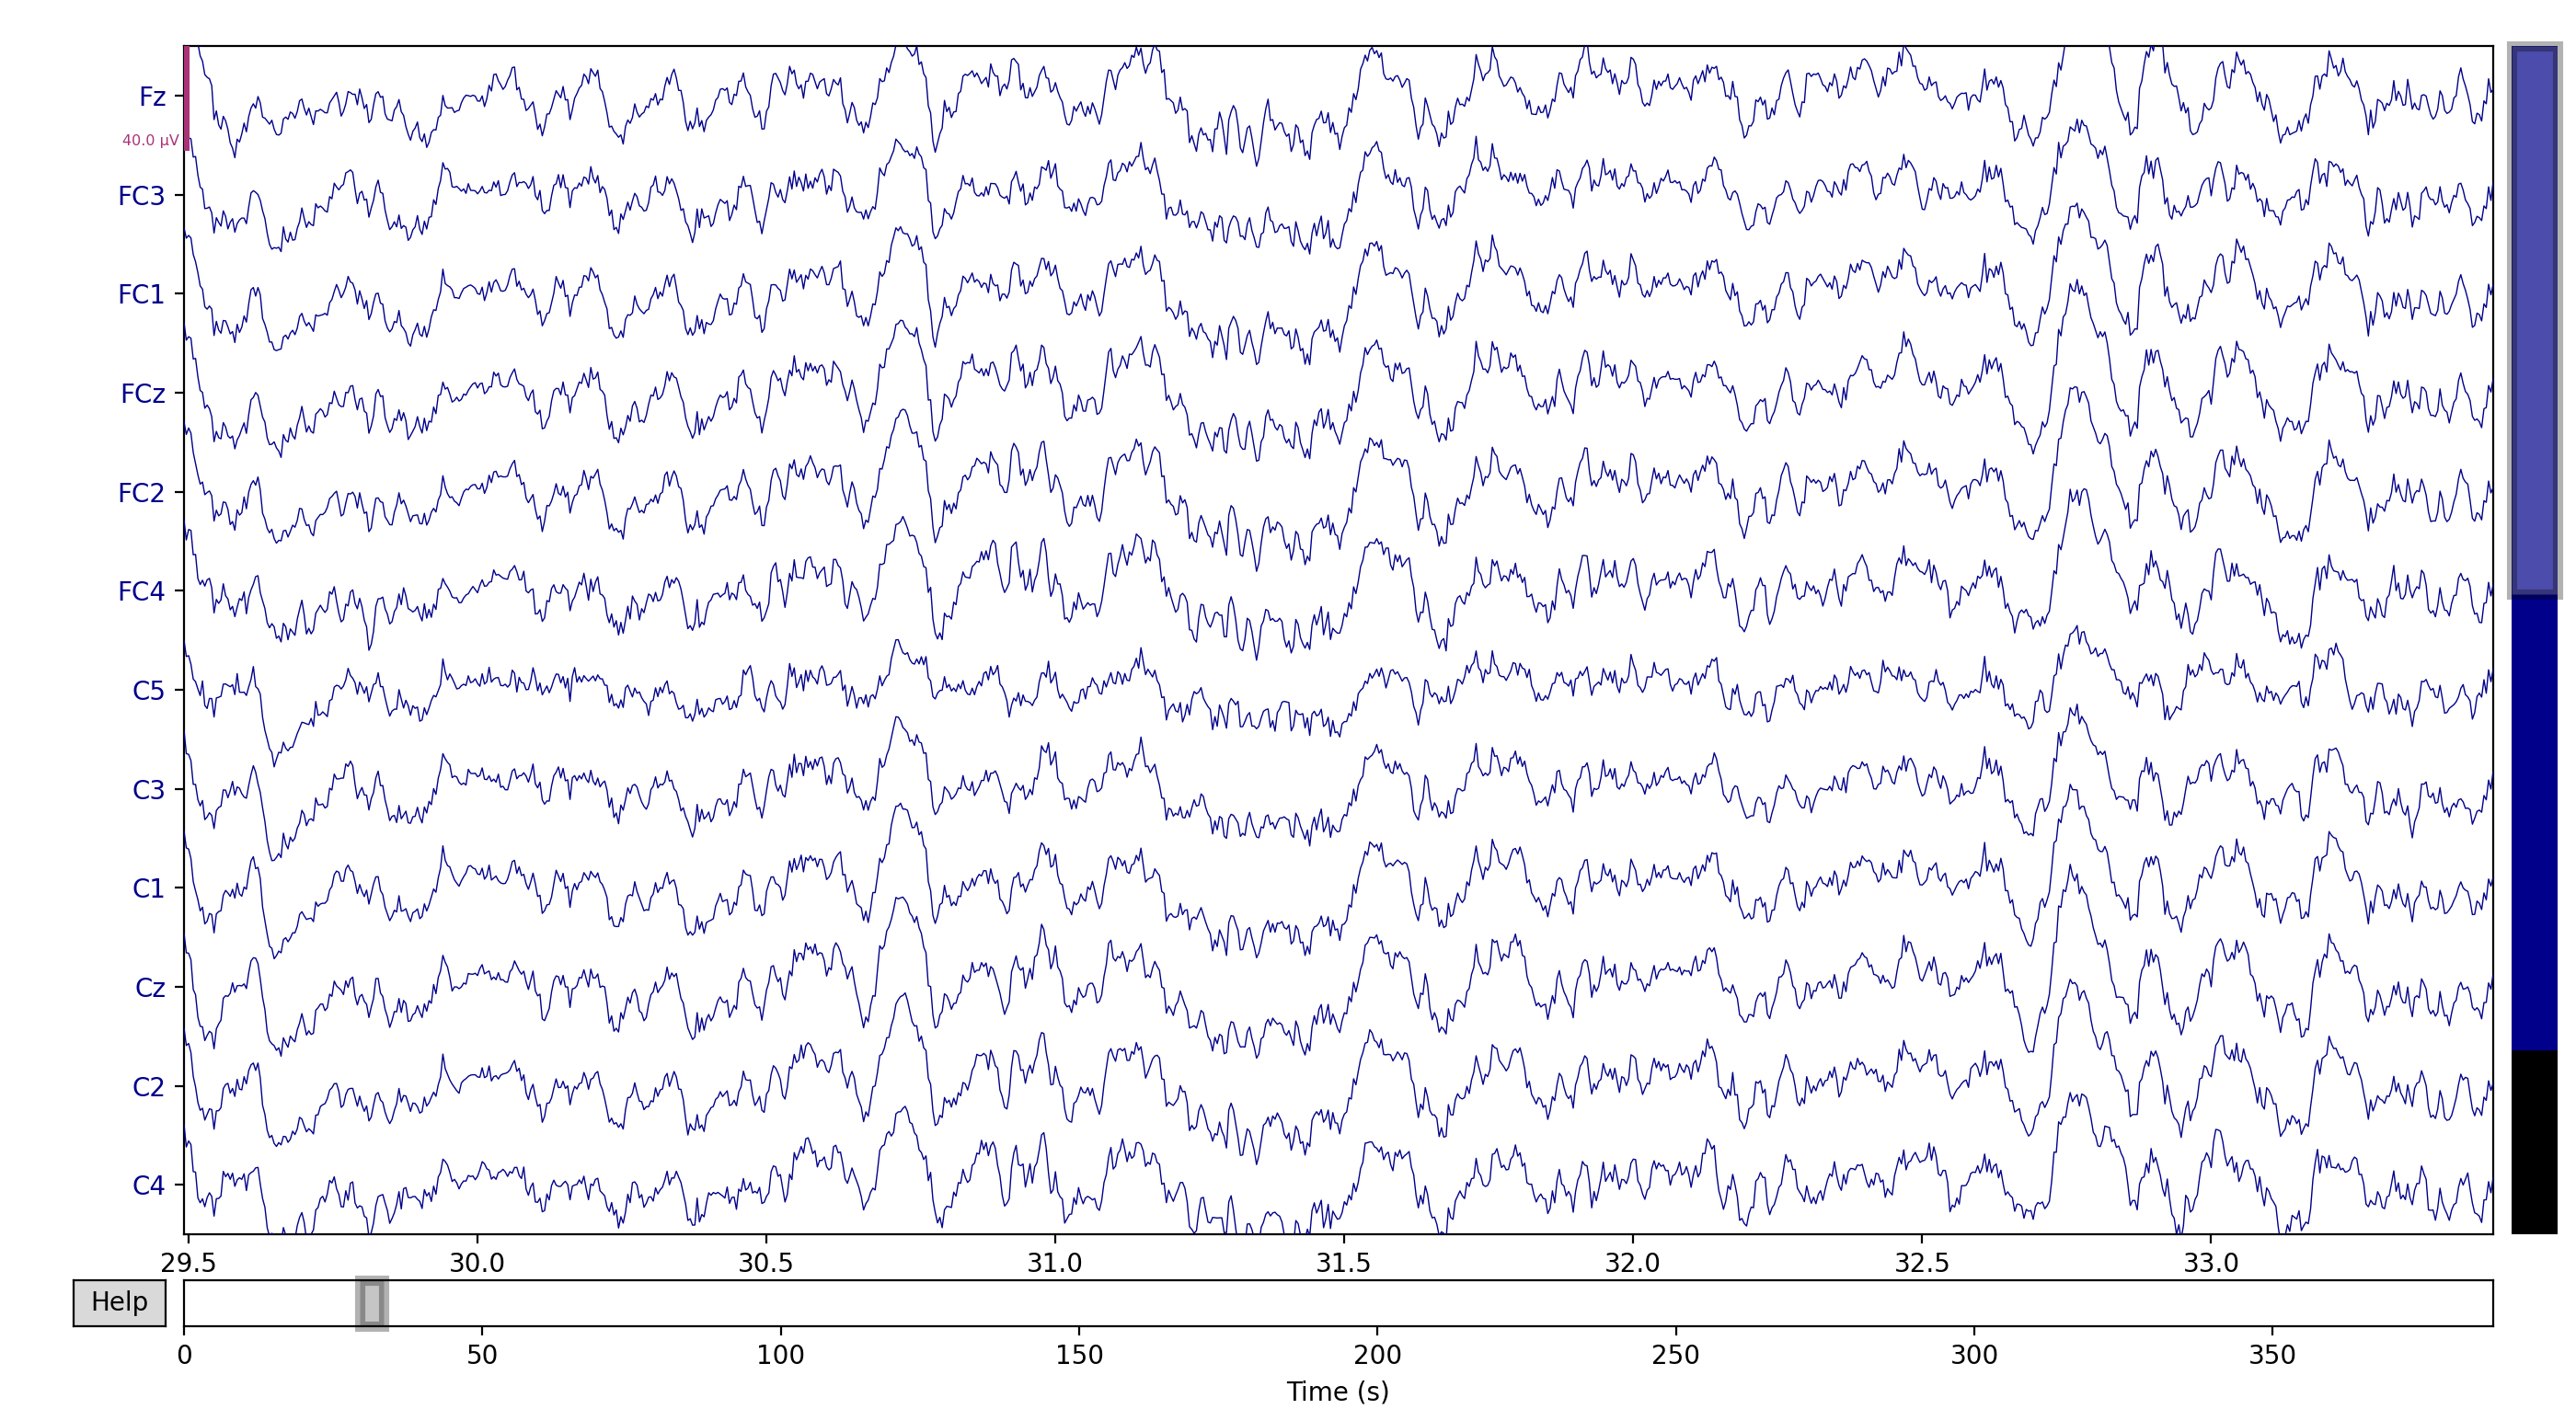

<IPython.core.display.Javascript object>


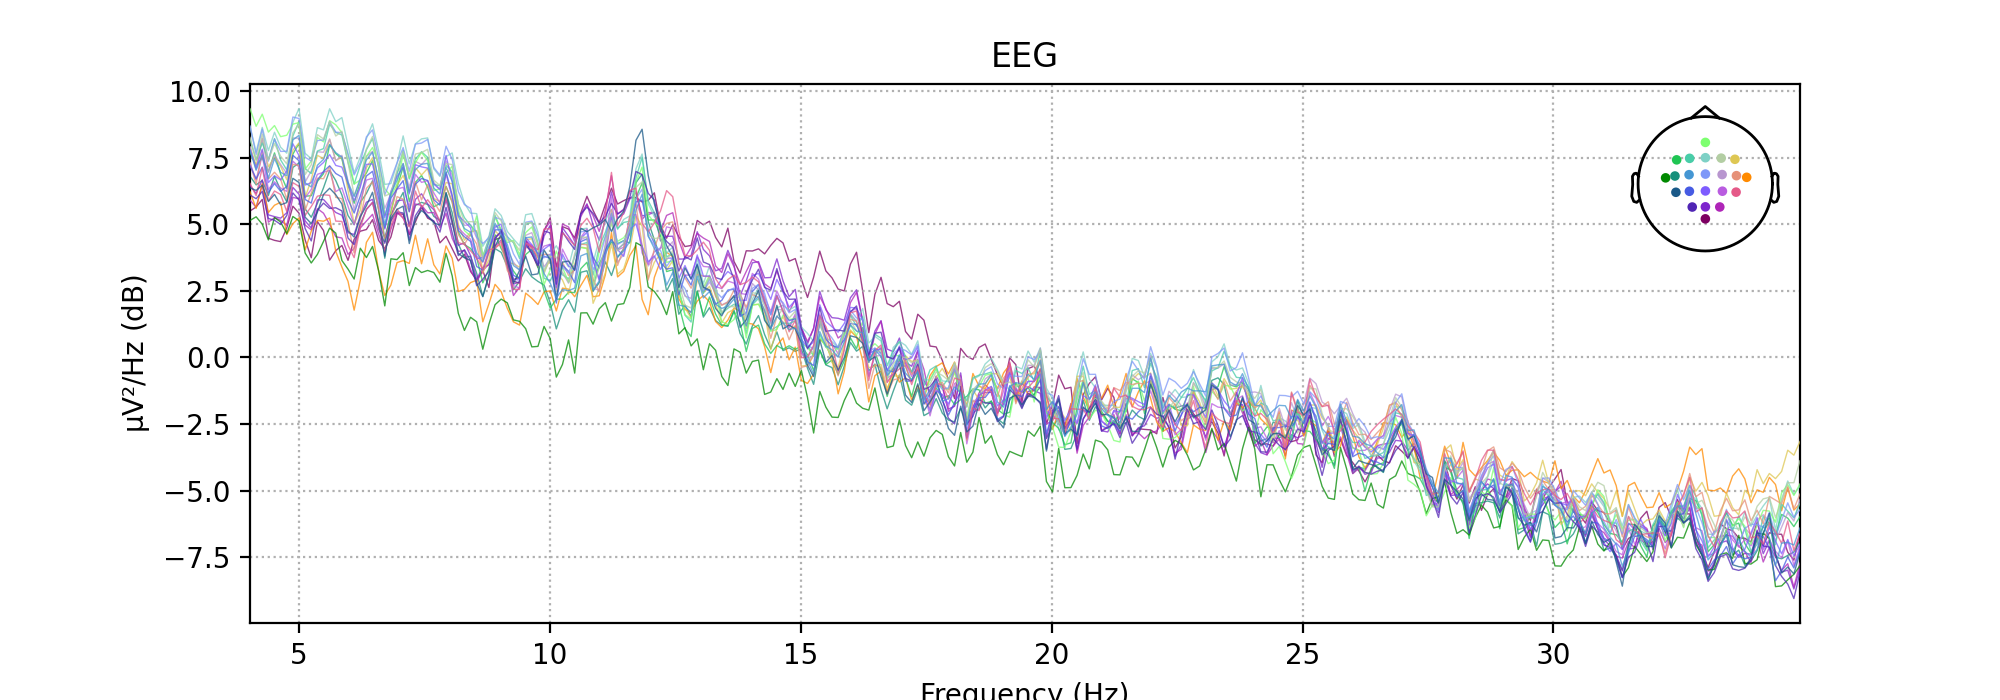

Effective window size : 8.192 (s)


In [3]:
data = dataset.get_data(subjects=[1])
subject, session, run = 1, "session_T", "run_0"
raw = data[subject][session][run]
_ = raw.plot_sensors(show_names=True)
_ = raw.plot(duration=4, n_channels=12, color={'eeg':'darkblue'})
_ = raw.plot_psd(fmin=4., fmax=35, picks=['eeg'])

## Unifying the preprocessing with Paradigm

Once we have instantiated a dataset, we have to choose a paradigm. This object is responsible for filtering the data, epoching it, and extracting the labels for each epoch. Note that each dataset comes with the names of the paradigms to which it might be associated. It would not make sense to process a P300 dataset with a MI paradigm.

When the paradigm is defined, you could obtain a numpy array for the data and the label and a pandas DataFrame with all the metainformation for each trial (subject, session, ...)

In [4]:
from moabb.paradigms import LeftRightImagery

paradigm = LeftRightImagery()
X, labels, meta = paradigm.get_data(dataset=dataset, subjects=[1])

print("The EEG is stored a (n_trials x n_channels x n_samples) array: {}".format(X.shape))
print()
print("The labels are also stored as an array: {} ...".format(labels[:5]))
print()
print("The metadata are store in a DataFrame:")
meta.head(10)

The EEG is stored a (n_trials x n_channels x n_samples) array: (288, 22, 1001)

The labels are also stored as an array: ['right_hand' 'left_hand' 'left_hand' 'right_hand' 'right_hand'] ...

The metadata are store in a DataFrame:


,subject,session,run
0,1,session_T,run_0
1,1,session_T,run_0
2,1,session_T,run_0
3,1,session_T,run_0
4,1,session_T,run_0
5,1,session_T,run_0
6,1,session_T,run_0
7,1,session_T,run_0
8,1,session_T,run_0
9,1,session_T,run_0


## Defining machine learning pipelines

Our goal is to evaluate the performance of a given classifier. Usually classifiers are applied on feature extracted from the data like ACP or ICA in general. In BCI, common feature extration step are CSP or other spatial filters. Pipelines allows to define all the steps needed to transform the data and to apply a classifier. This is good practices to ensure a fair evaluation and to avoid [leaking information](https://scikit-learn.org/stable/common_pitfalls.html) to the classifier.

In [5]:
from mne.decoding import CSP
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.pipeline import Pipeline

pipeline = Pipeline(steps=[('csp', CSP(n_components=8)), 
                           ('lda', LDA())])

## Evaluating our pipeline on the dataset

To evaluate the score of this pipeline, we use an `Evaluation`. We need to specify which paradigm we want to consider, a list with the datasets to analyze, and whether the scores should be recalculated each time we run the evaluation or if MOABB should create a cache file.

Note that there are three different evaluation available in MOABB:

* `WithinSessionEvaluation`, a cross-validation procedure where the training and testing partitions are from the same recording session of the dataset
* `CrossSessionEvaluation` takes all but one session for training and the remaining one for testing
* `CrossSubjectEvaluation`, same thing for subjects: this is a leave-one-subject-out type of evaluation

Here, we will use a `WithinSessionEvaluation` to benchmark the `csp+lda` pipeline on the dataset `BNCI2014001` with the `LeftRightImagery` paradigm. 

In [6]:
from moabb import set_log_level
from moabb.evaluations import WithinSessionEvaluation
import warnings


set_log_level("error")
warnings.filterwarnings("ignore")

datasets = [dataset]
pipelines = {'csp+lda': pipeline}

evaluation = WithinSessionEvaluation(
    paradigm=paradigm,
    datasets=datasets,
    overwrite=True
)
results = evaluation.process(pipelines)

The results are stored in a DataFrame. They could be exported to CSV/Excel files or used with [seaborn](https://seaborn.pydata.org/) to make nice figures.

In [7]:
results

,score,time,samples,subject,session,channels,n_sessions,dataset,pipeline
0,0.959932,0.236131,144.0,1,session_E,22,2,001-2014,csp+lda
1,0.932925,0.267387,144.0,1,session_T,22,2,001-2014,csp+lda
2,0.617007,0.252011,144.0,2,session_E,22,2,001-2014,csp+lda
3,0.643605,0.249176,144.0,2,session_T,22,2,001-2014,csp+lda
4,0.994286,0.206190,144.0,3,session_E,22,2,001-2014,csp+lda
5,0.994014,0.253454,144.0,3,session_T,22,2,001-2014,csp+lda
6,0.826395,0.244807,144.0,4,session_E,22,2,001-2014,csp+lda
7,0.830272,0.271664,144.0,4,session_T,22,2,001-2014,csp+lda
8,0.683537,0.256213,144.0,5,session_E,22,2,001-2014,csp+lda
9,0.575782,0.236844,144.0,5,session_T,22,2,001-2014,csp+lda


In [8]:
results.to_csv("./myresults.csv")

<IPython.core.display.Javascript object>


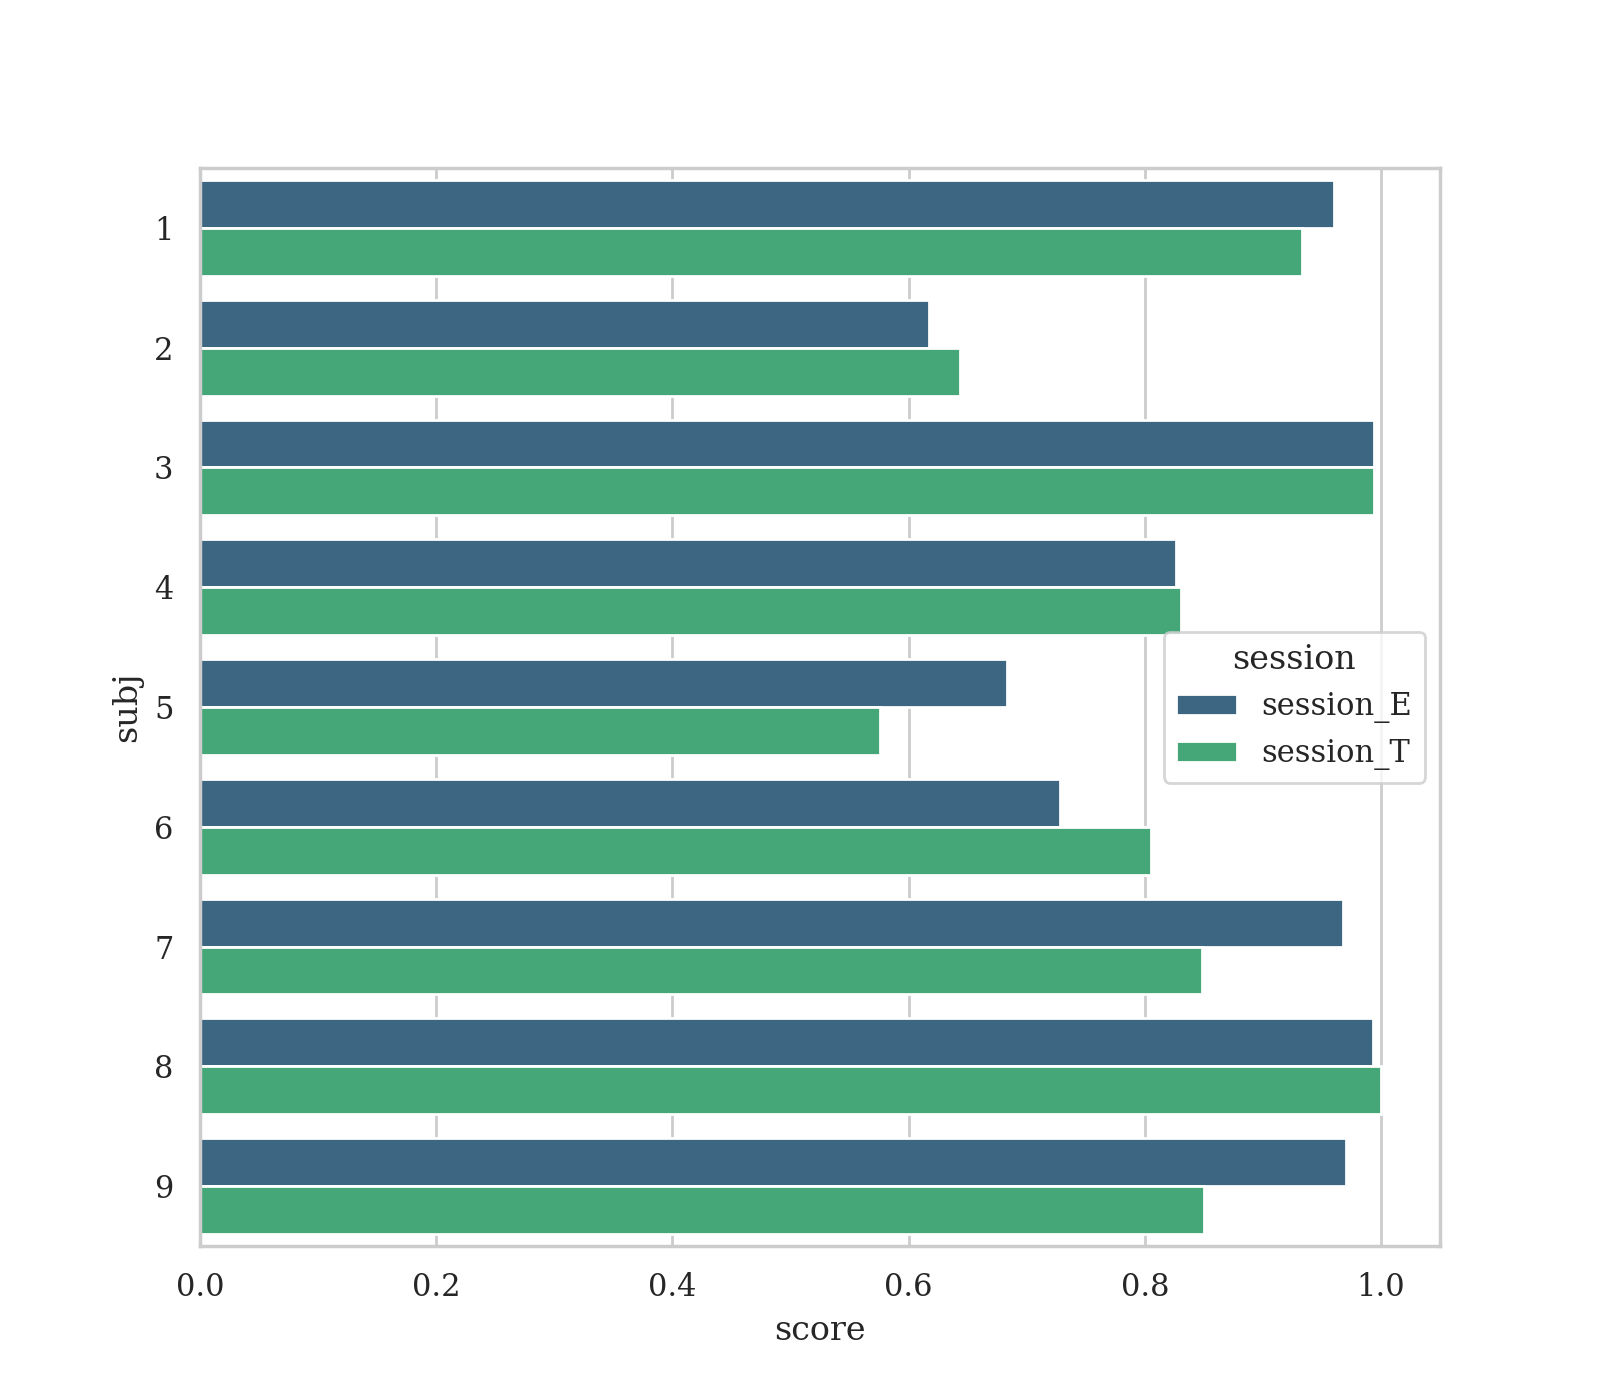

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, ax = plt.subplots(figsize=(8, 7))
results["subj"] = results["subject"].apply(str)
sns.barplot(
    x="score", y="subj", hue="session", data=results, orient="h", palette="viridis", ax=ax
)
fig.show()

## Setting up large benchmarks

MOABB is design to handled large benchmarks, conducted on several datasets to assess many pipelines. This is very easy to scale up. 

It is very easy to search the datasets for specific criteria:

In [10]:
from moabb.datasets.utils import dataset_search
print("All MI datasets that includes at least right hand and feet motor imagery:")
for dset in dataset_search(paradigm="imagery", has_all_events=True, events=['right_hand', 'feet']):
    print(dset)
  
print()
print("All P300 datasets with at least two sessions:")
for dset in dataset_search(paradigm="p300", multi_session=True):
    print(dset)
    
print()
print("All SSVEP datasets with at least 10 subjects:")
for dset in dataset_search(paradigm="ssvep", min_subjects=10):
    print(dset)


All MI datasets that includes at least right hand and feet motor imagery:

All P300 datasets with at least two sessions:

All SSVEP datasets with at least 10 subjects:


Let's start by finding all datasets that includes at least left-hand and right-hand motor imagery and load all of them!

In [11]:
paradigm = LeftRightImagery()

for dset in paradigm.datasets:
    print(dset)

In [12]:
from moabb.datasets import (
    BNCI2014001, 
    BNCI2014004, 
    Cho2017, 
    Lee2019_MI, 
    MunichMI, 
    PhysionetMI, 
    Schirrmeister2017, 
    Shin2017A, 
    Weibo2014, 
    Zhou2016
)

all_lr = [BNCI2014001(),
          BNCI2014004(),
          Cho2017(),
          Lee2019_MI(),
          MunichMI(),
          PhysionetMI(),
          Schirrmeister2017(),
          Shin2017A(),
          Weibo2014(),
          Zhou2016()]

We could compare several pipelines, so let's compare
- CSP and LDA
- MDM
- LDA in the tangent space

In [13]:
from mne.decoding import CSP
from pyriemann.estimation import Covariances
from pyriemann.tangentspace import TangentSpace
from pyriemann.classification import MDM
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA


pipelines = {}
pipelines["csp+lda"] = Pipeline(steps=[('csp', CSP(n_components=8)), 
                                       ('lda', LDA())])
pipelines["mdm"] = Pipeline(steps=[('cov', Covariances("oas")), 
                                   ('mdm', MDM(metric="riemann"))])
pipelines["tgsp+lda"] = Pipeline(steps=[('cov', Covariances("oas")), 
                                        ('tg', TangentSpace(metric="riemann")),
                                        ('lda', LDA())])

As it is common in machine learning, we can set up a grid search technique to find the best possible parameter for a pipeline. For example, we could add a powerful logistic regression classifier, also called elastic-net, and search for the best l1-l2 ratio and regularization strength. We will this add two new classifiers:

- CSP and elastic net
- elastic net in the tangent space

In [14]:
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV


parameters = {'l1_ratio': [0.2, 0.5, 0.8],
              'C': np.logspace(-1, 1, 3)}
elasticnet = GridSearchCV(LogisticRegression(penalty='elasticnet', solver='saga'),
                          parameters)

pipelines["csp+en"] = Pipeline(steps=[('csp', CSP(n_components=8)),
                                      ('en', elasticnet)])
pipelines["tgsp+en"] = Pipeline(steps=[('cov', Covariances("oas")), 
                                       ('tg', TangentSpace(metric="riemann")),
                                       ('en', elasticnet)])

In [15]:
set_log_level("error")
warnings.filterwarnings("ignore")

LReval = WithinSessionEvaluation(
    paradigm=paradigm,
    datasets=all_lr,
    n_jobs=-1,
    suffix="workshop",
    overwrite=False
)
results = LReval.process(pipelines)

In [16]:
results

,score,time,samples,subject,session,channels,n_sessions,dataset,pipeline
0,0.955918,0.249479,144.0,1,session_E,22,2,001-2014,mdm
1,0.940680,0.070078,144.0,1,session_T,22,2,001-2014,mdm
2,0.532381,0.067510,144.0,2,session_E,22,2,001-2014,mdm
3,0.607959,0.070371,144.0,2,session_T,22,2,001-2014,mdm
4,0.990340,0.093519,144.0,3,session_E,22,2,001-2014,mdm
...,...,...,...,...,...,...,...,...,...
2305,0.974000,0.059763,100.0,3,session_1,14,3,Zhou 2016,csp+lda
2306,0.992000,0.060934,100.0,3,session_2,14,3,Zhou 2016,csp+lda
2307,0.982716,0.059840,90.0,4,session_0,14,3,Zhou 2016,csp+lda
2308,0.998000,0.059681,100.0,4,session_1,14,3,Zhou 2016,csp+lda


We could generate an overall plot, that show for all datasets and pipelines the score obtain by each subjects. Each color dot is the score of a subject.

<IPython.core.display.Javascript object>


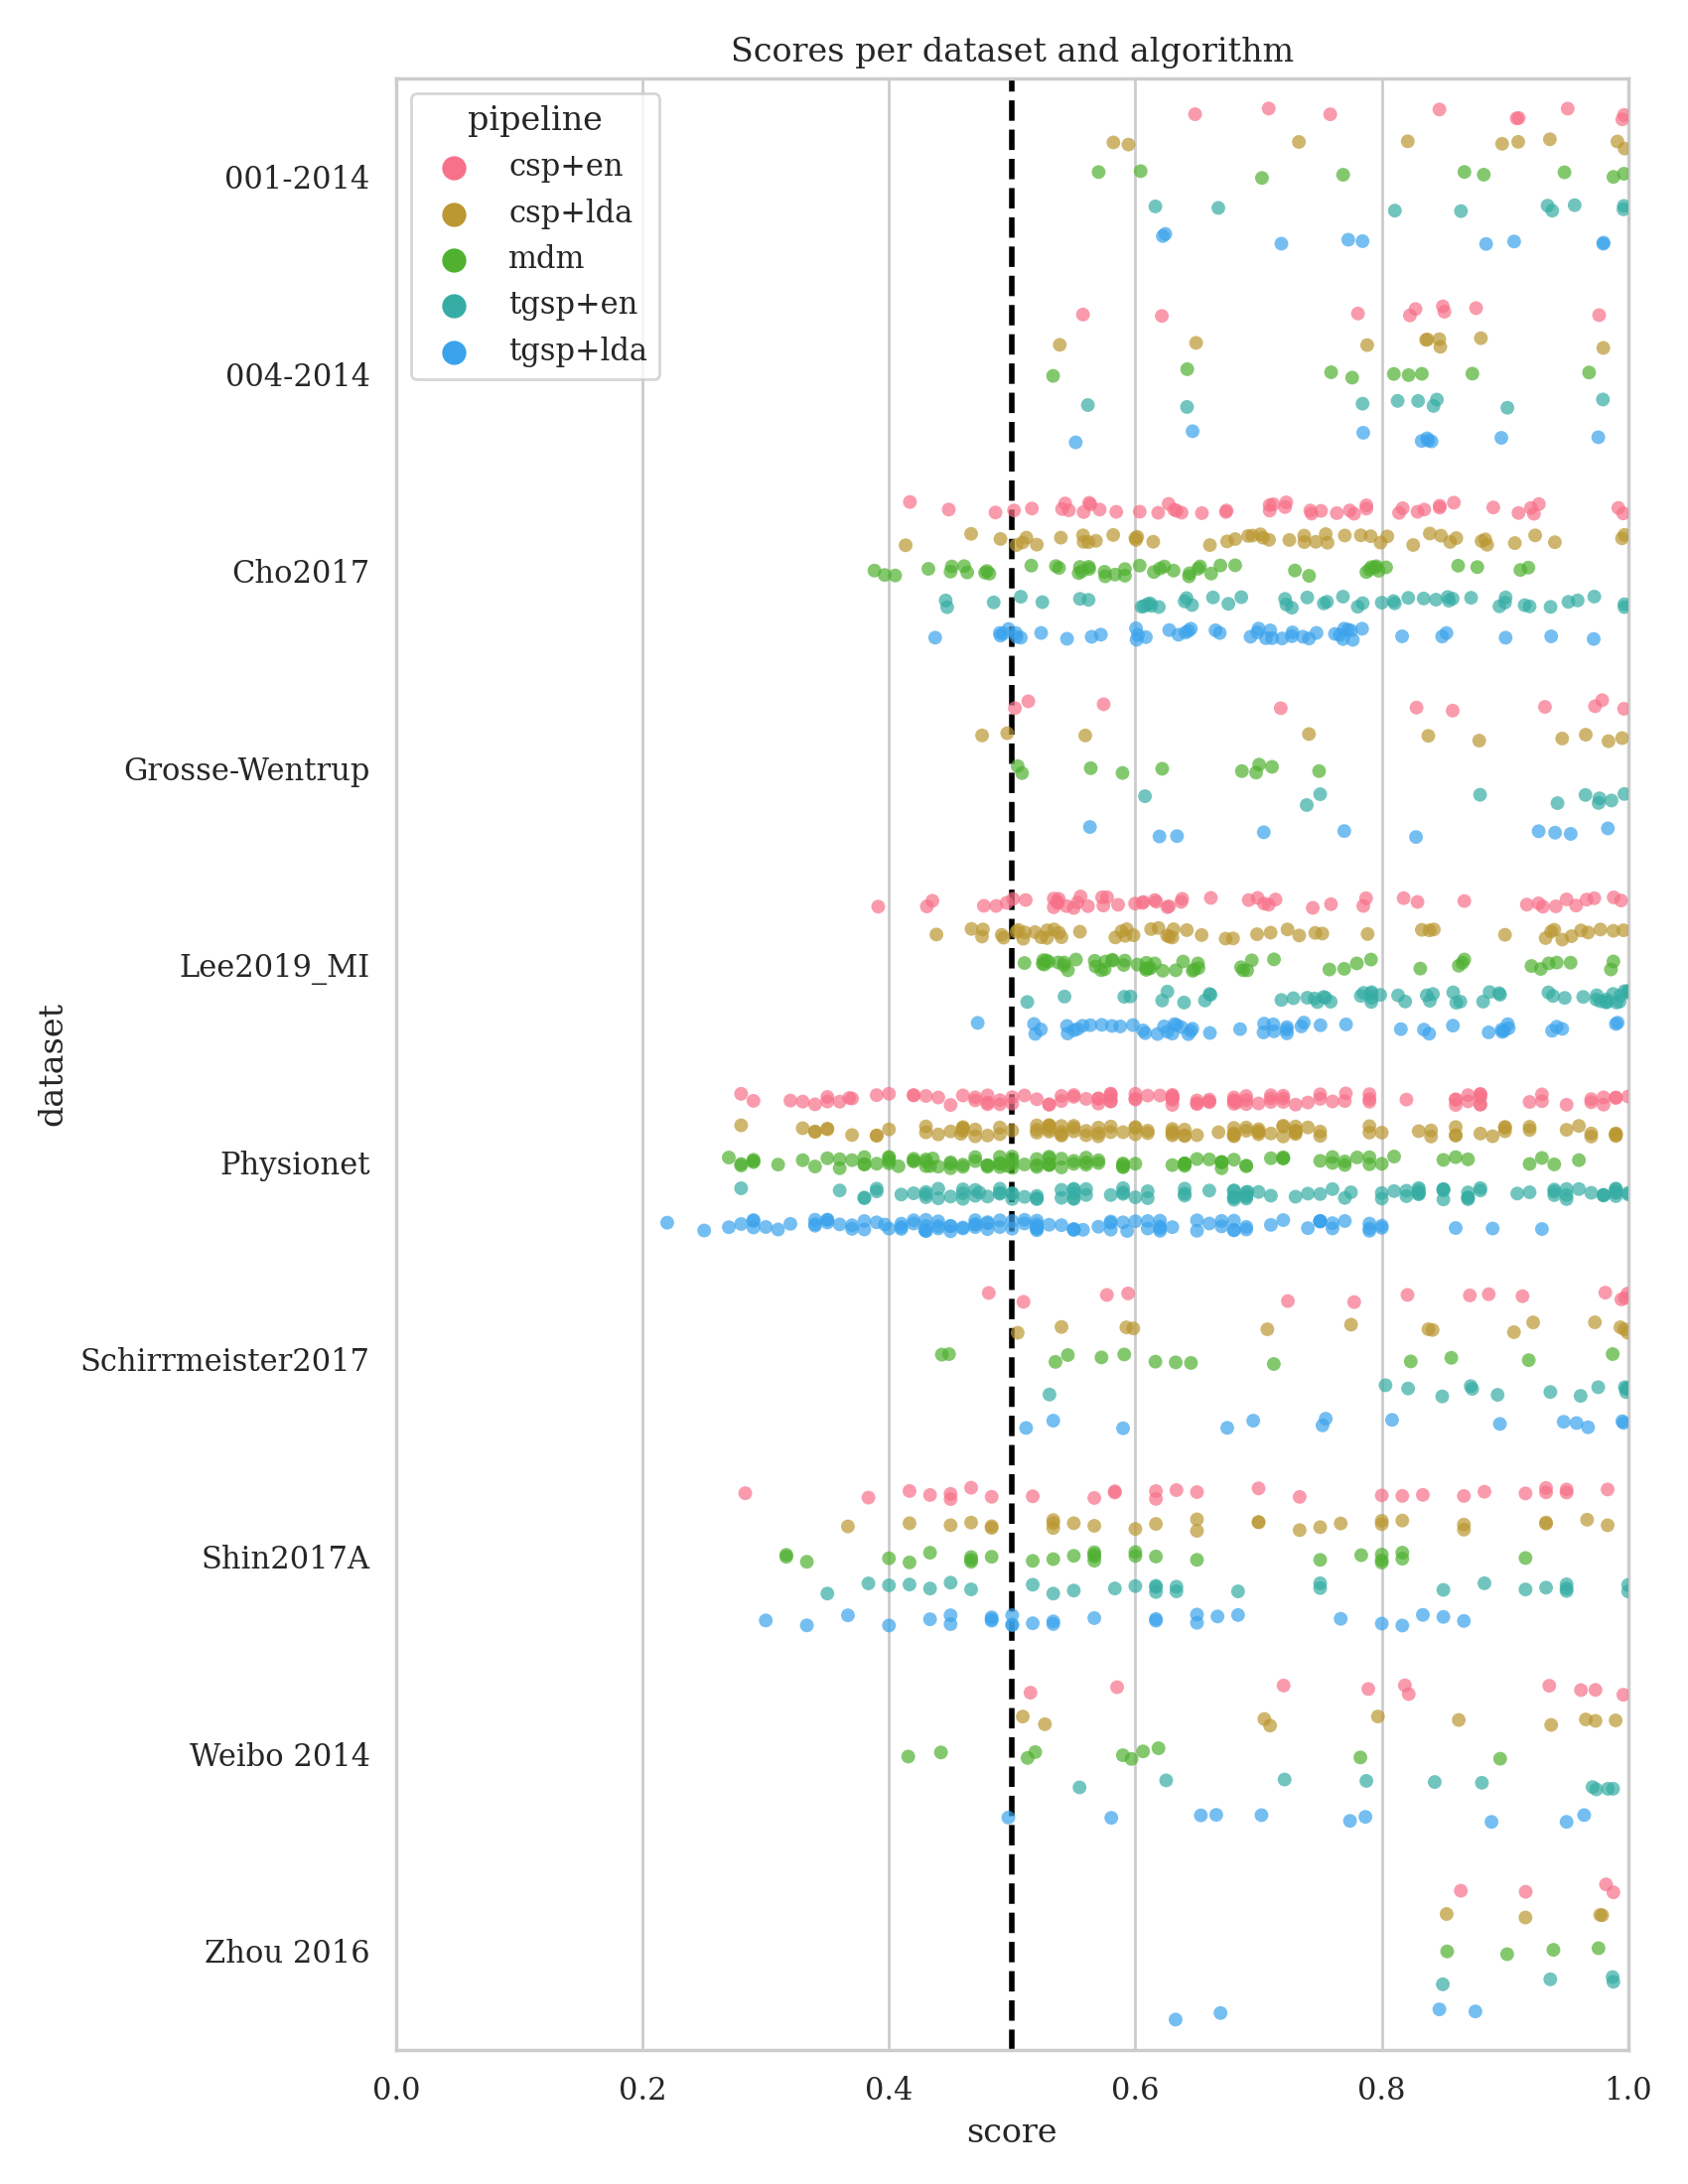

In [17]:
import moabb.analysis.plotting as moabb_plt

fig = moabb_plt.score_plot(results)

It is also possible to show the so-called "paired plot" to compare two given pipelines, the pipeline with most of the dot on its side of the line is the best.

<IPython.core.display.Javascript object>


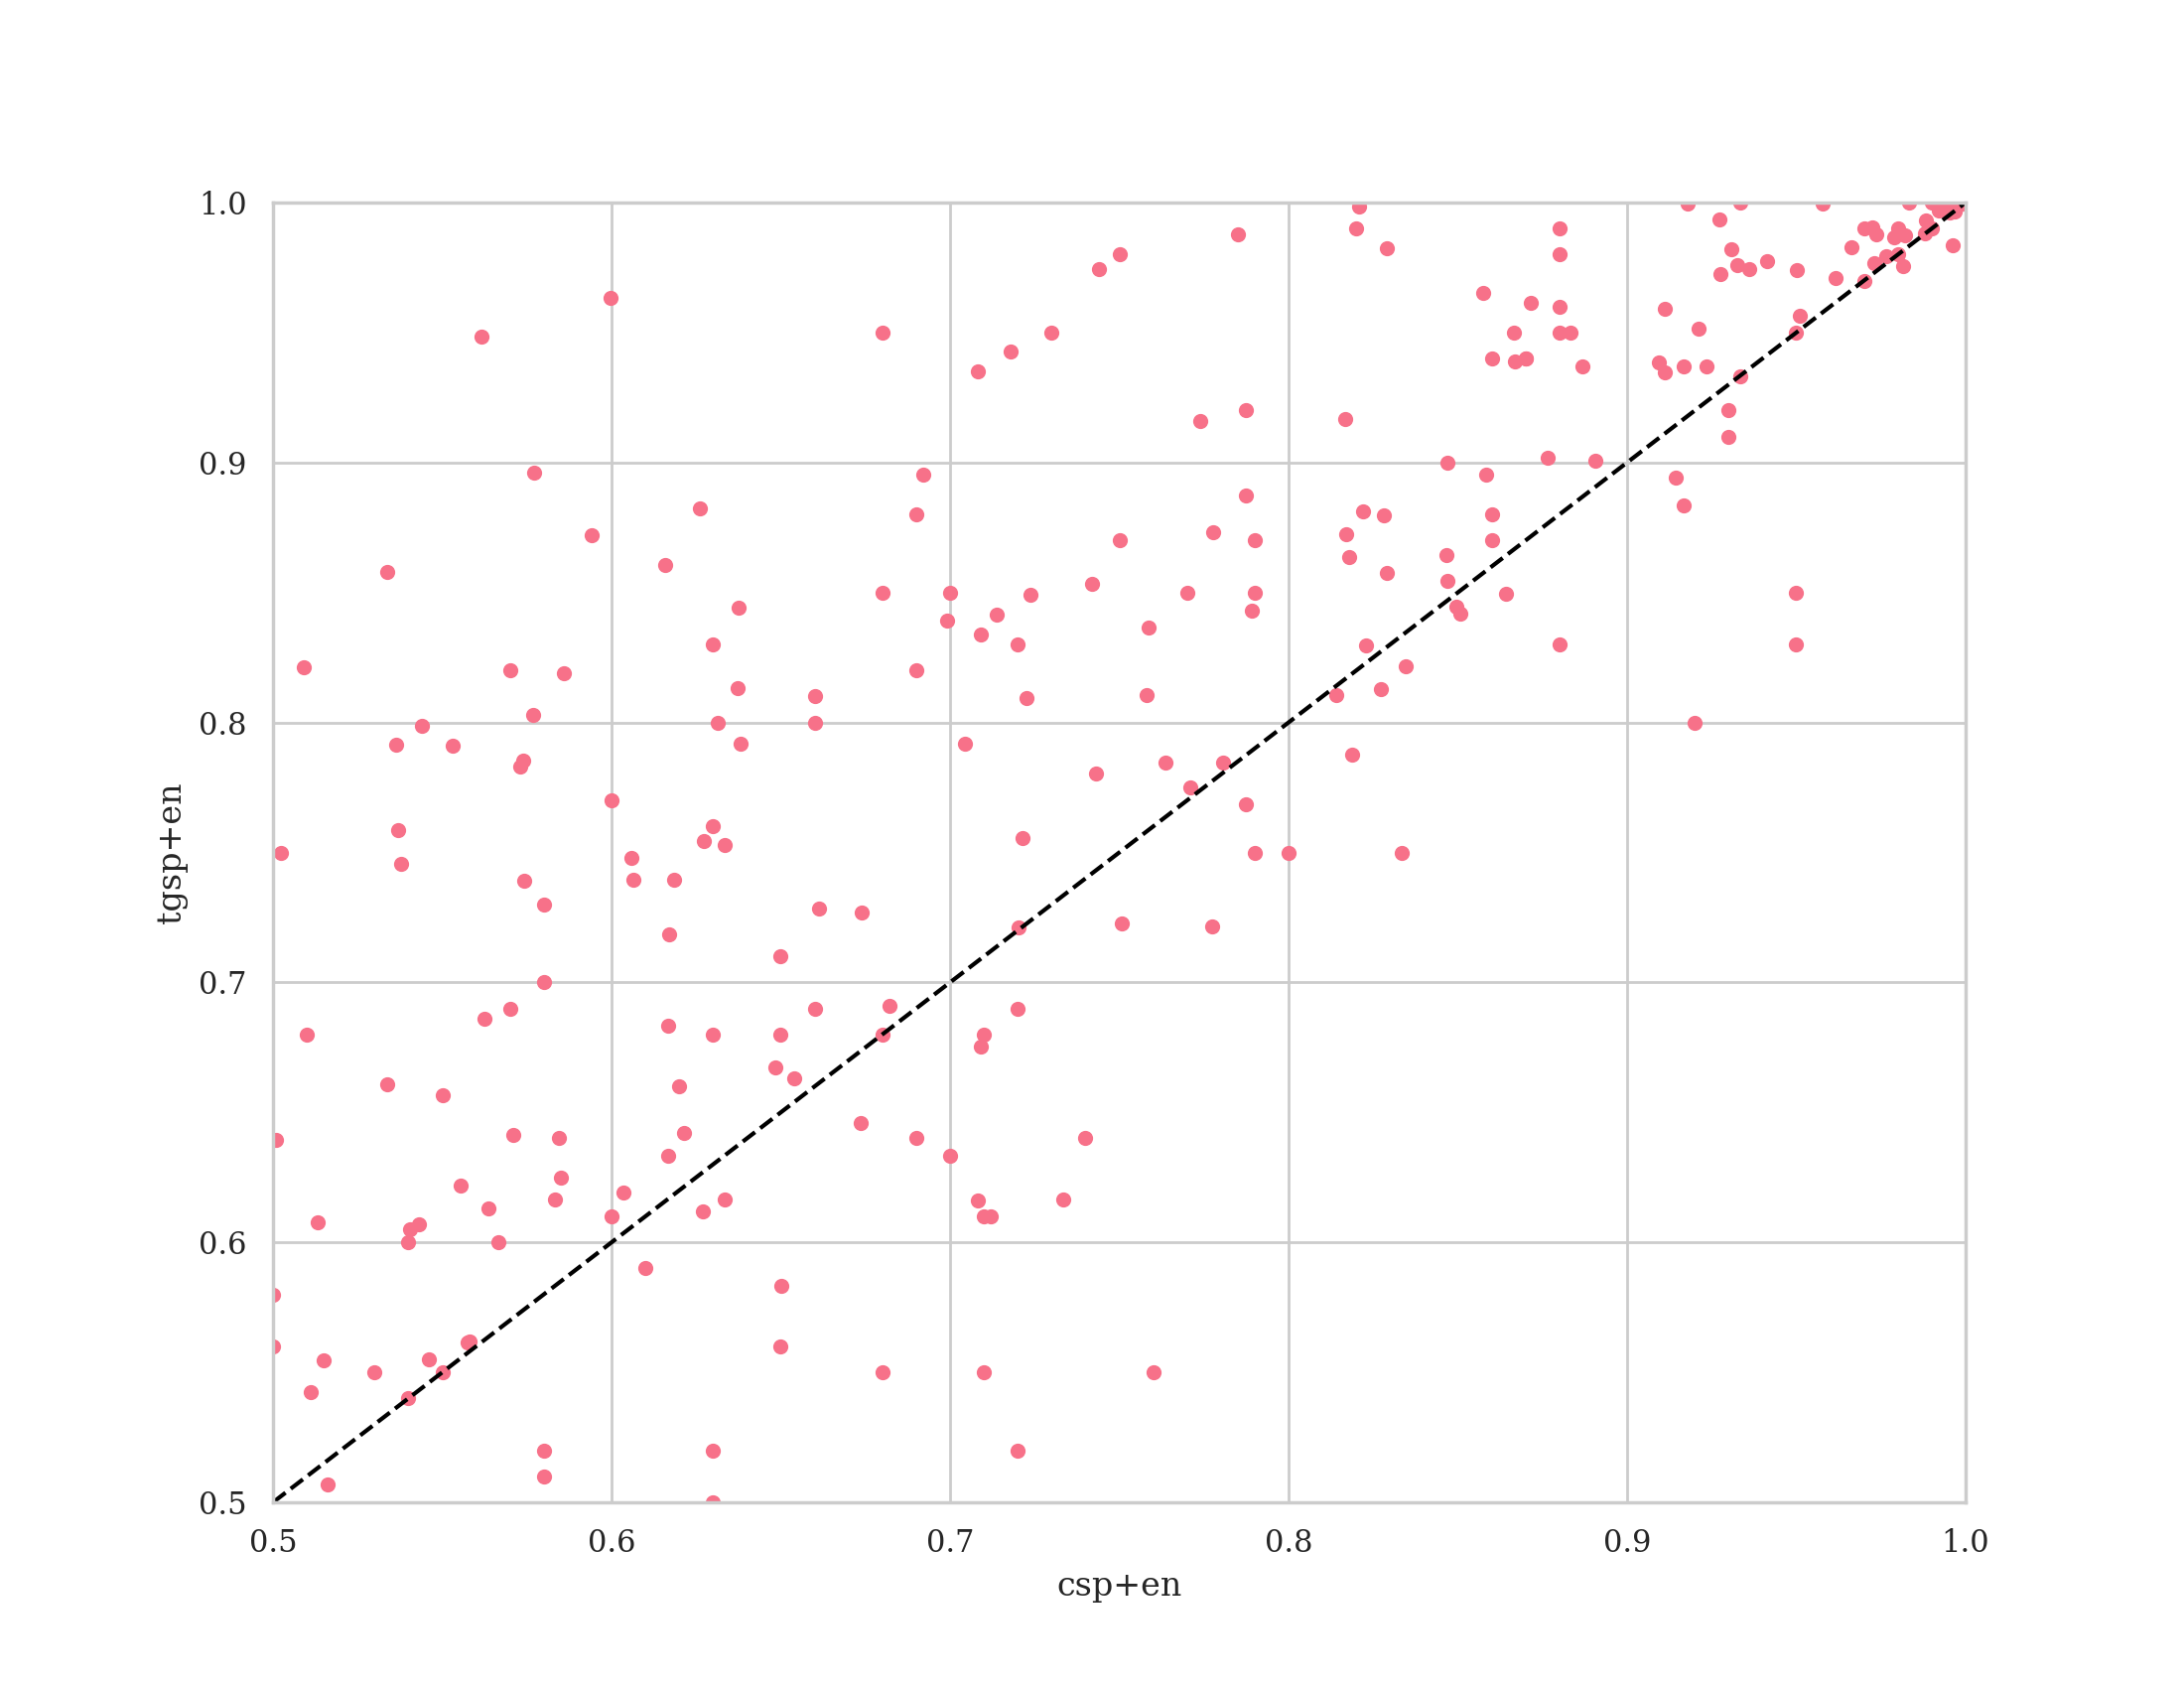

In [18]:
fig = moabb_plt.paired_plot(results, "csp+en", "tgsp+en")

<IPython.core.display.Javascript object>


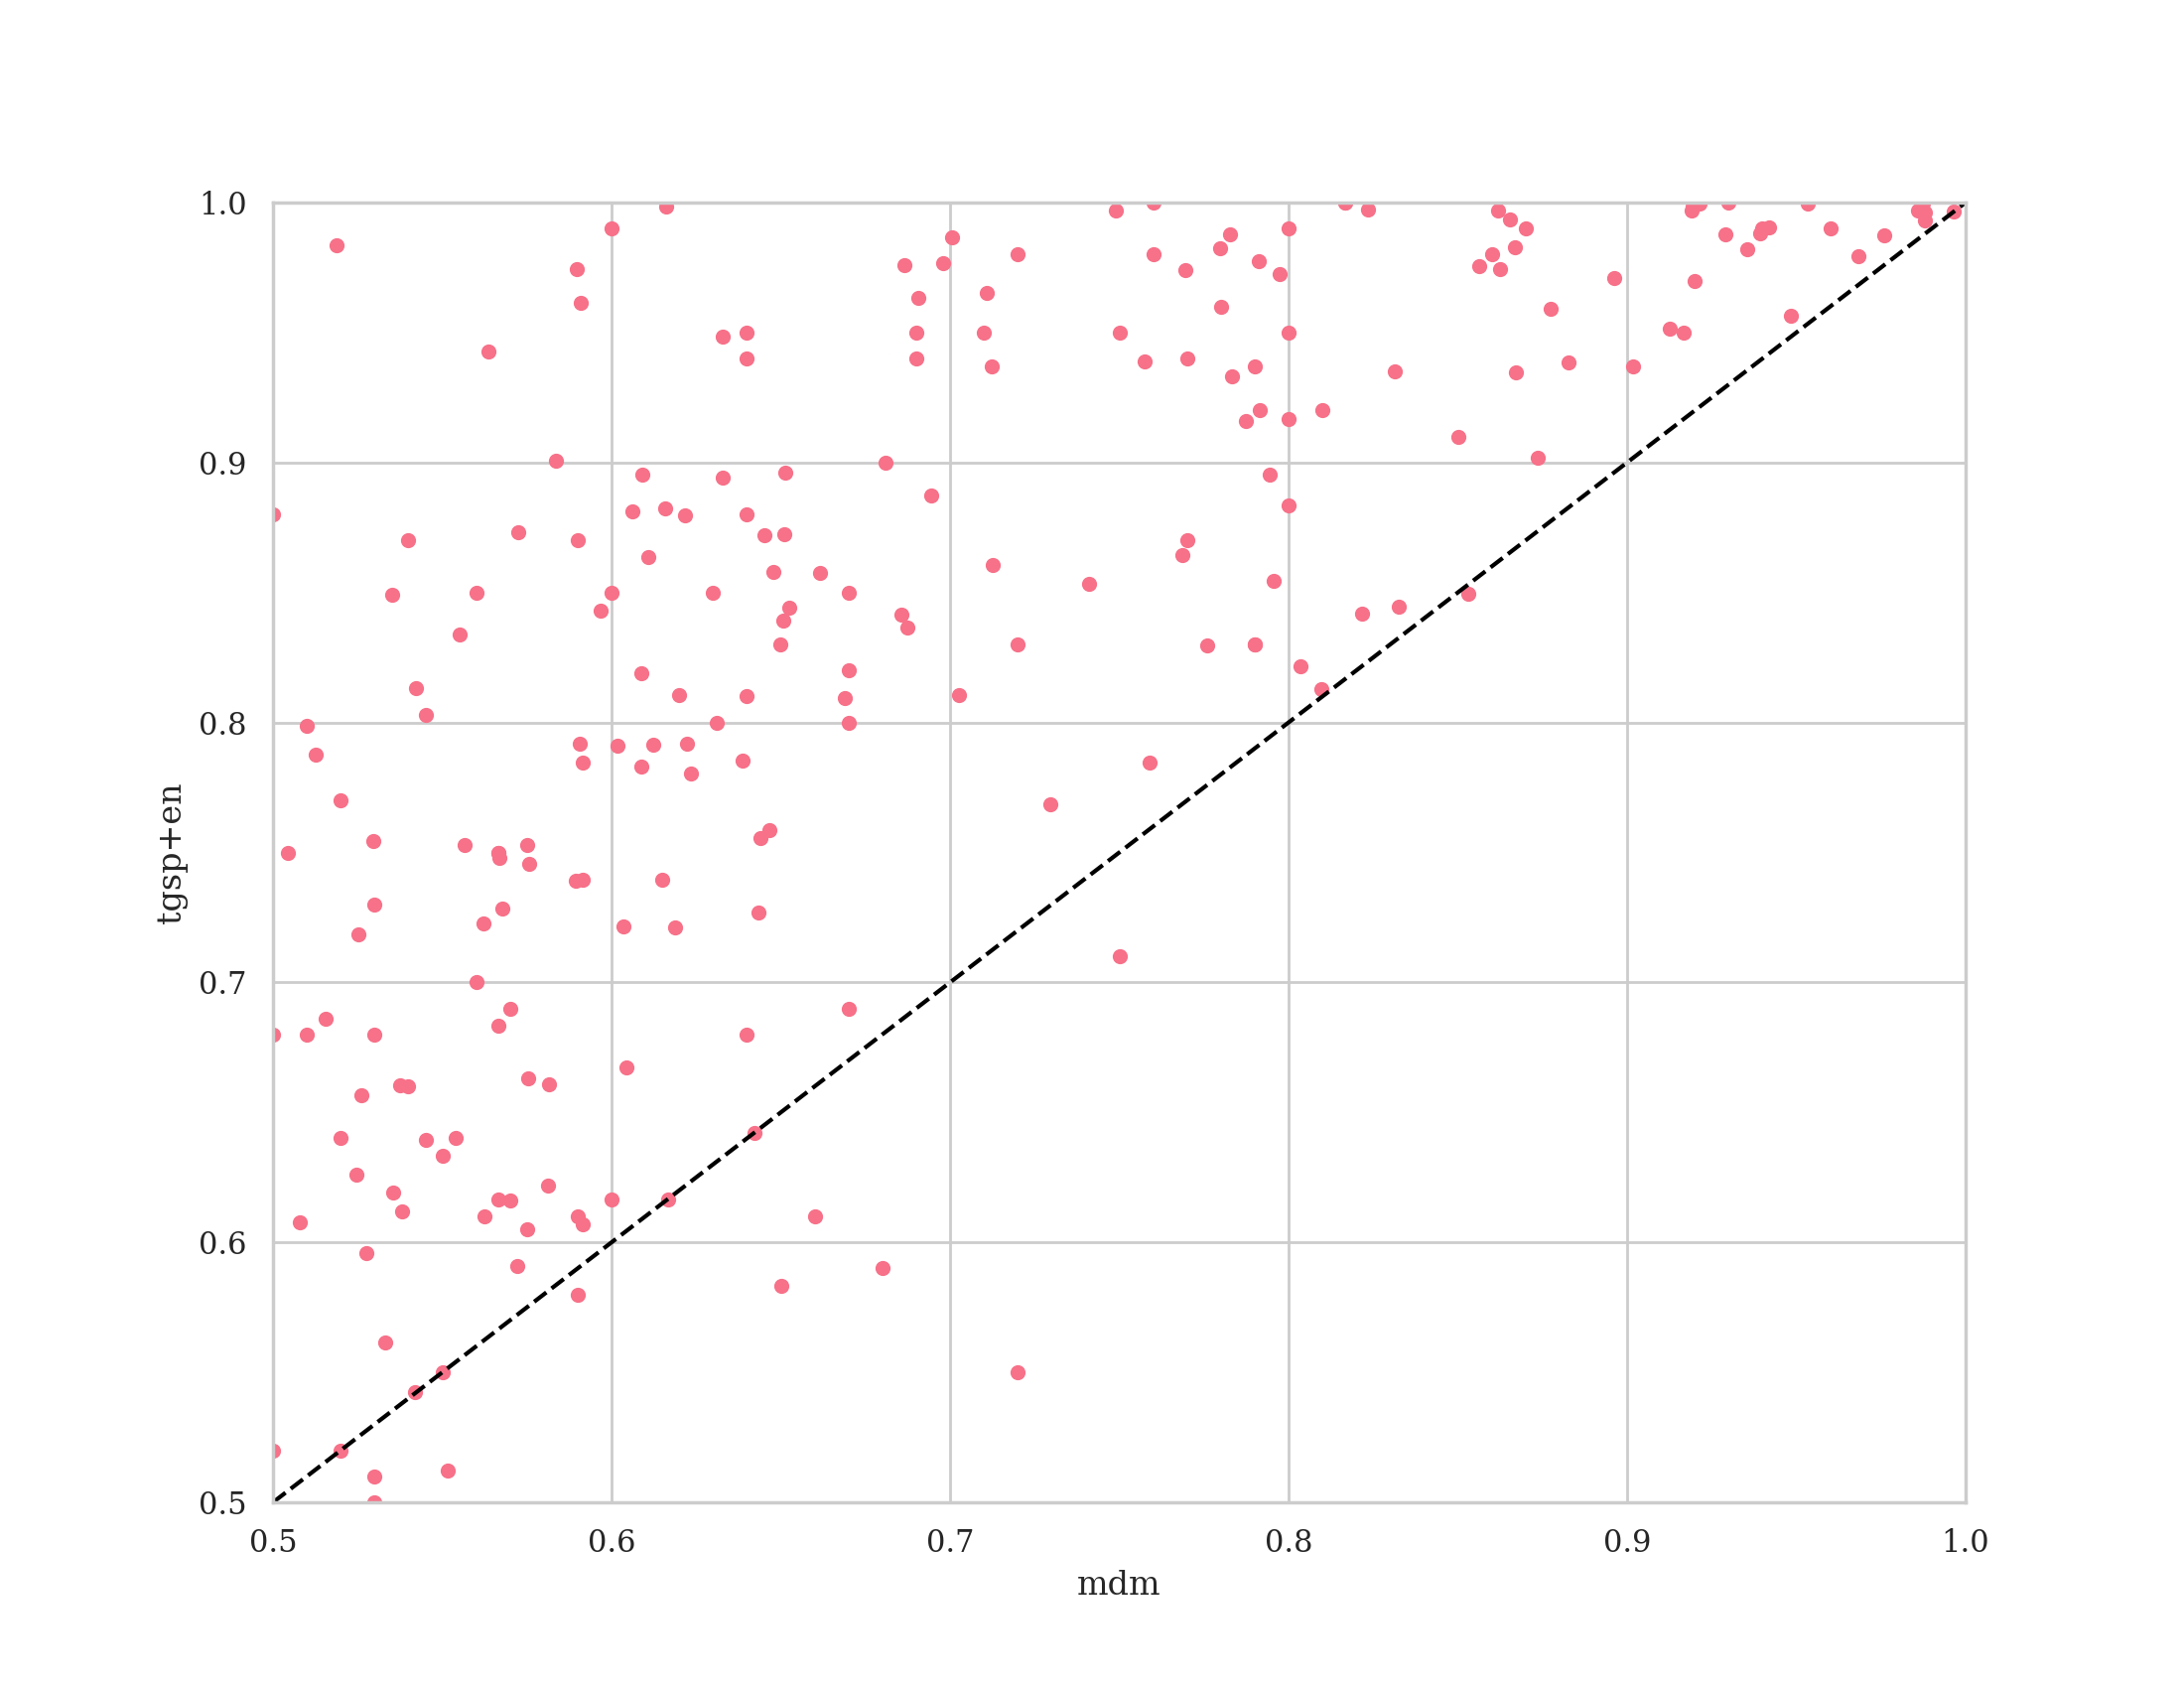

In [19]:
fig = moabb_plt.paired_plot(results, "mdm", "tgsp+en")

## Statistical testing and meta-analysis

To display the statistical significance of the pipeline results, MOABB could compute meta-analysis indicators and find significant differences.

The meta-analysis style plot shows the standardized mean difference within each tested dataset for the two algorithms in question, in addition to a meta-effect and significances both per-dataset and overall.

<IPython.core.display.Javascript object>


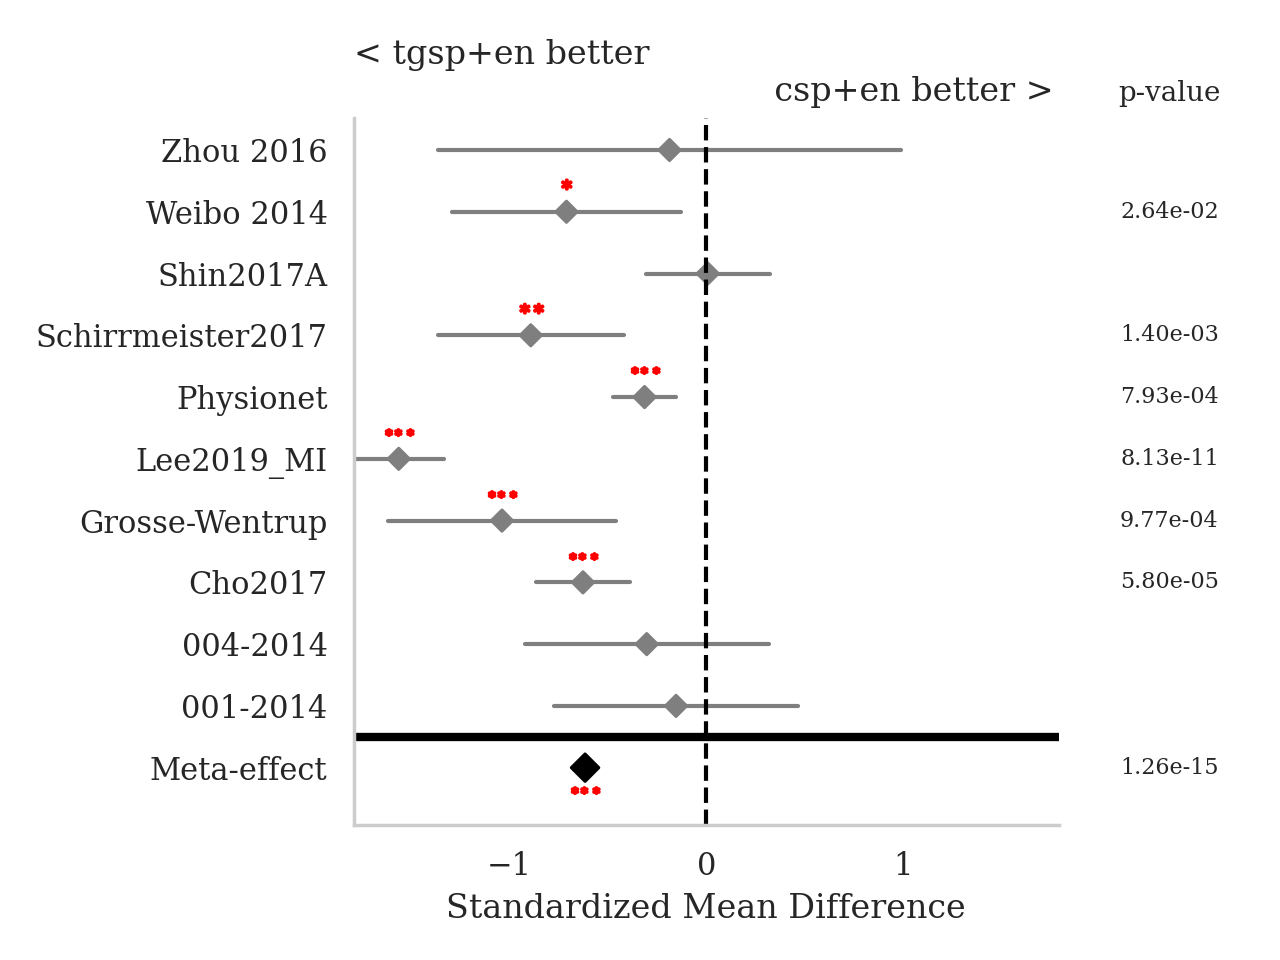

In [20]:
from moabb.analysis.meta_analysis import (
    compute_dataset_statistics,
    find_significant_differences,
)

stats = compute_dataset_statistics(results)
P, T = find_significant_differences(stats)

fig = moabb_plt.meta_analysis_plot(stats, "csp+en", "tgsp+en")

The summary plot shows the effect and significance related to the hypothesis that the algorithm on the y-axis significantly out-performed the algorithm on the x-axis over all datasets

<IPython.core.display.Javascript object>


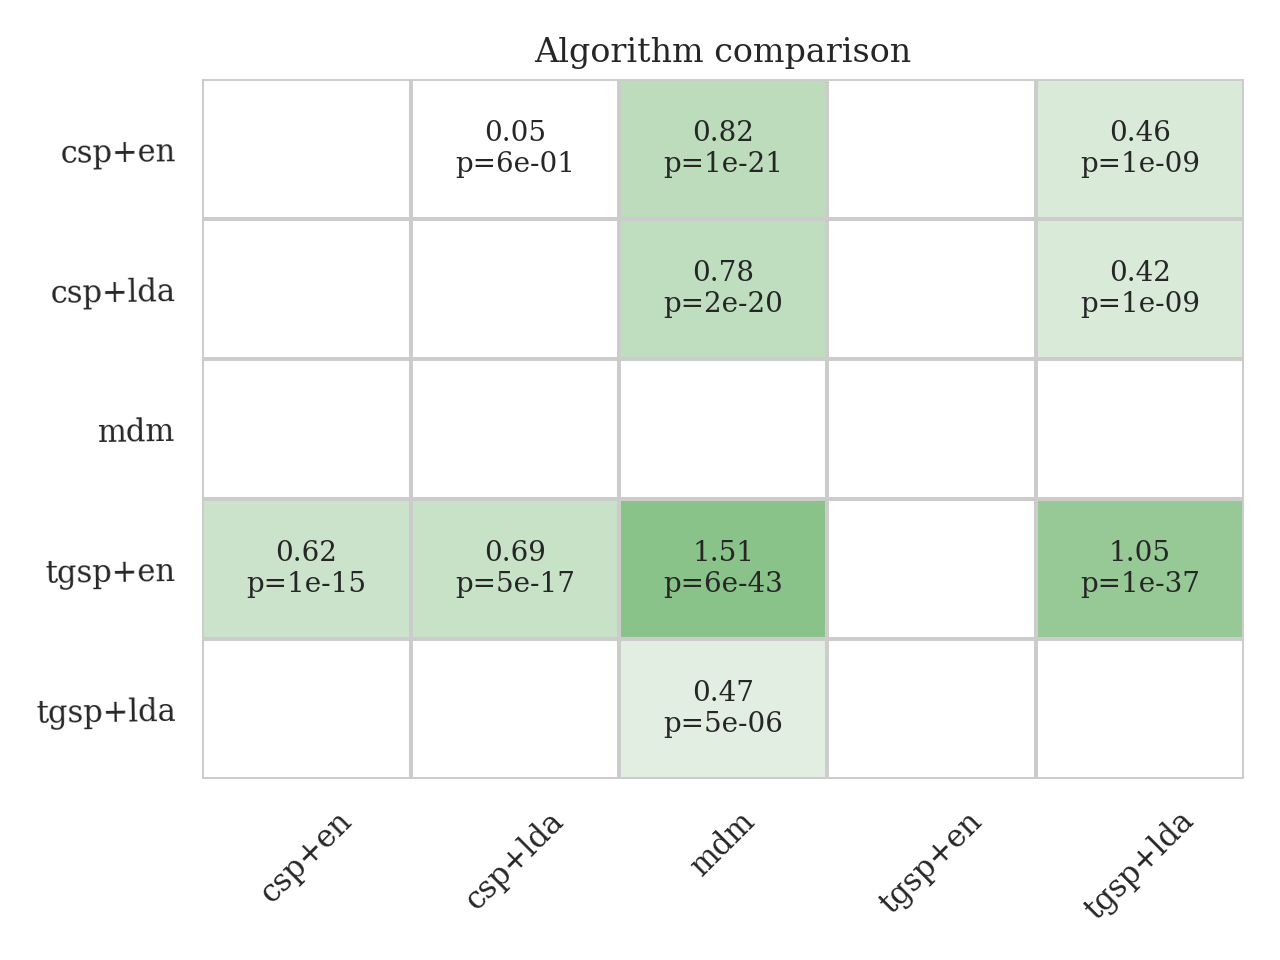

In [21]:
_ = moabb_plt.summary_plot(P, T)